In [77]:
%load_ext autoreload
%autoreload 2

import os
import sys
HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sns.set_palette("tab10")
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
loaded = False

# Load BioBank Components

In [4]:
DEV_MODE = False
SIGNIFIER = ""

if not loaded:
    biobank_data, biobank_index, med_code_mapping = data_tools.load_all_biobank_components(DEV_MODE, signifier=SIGNIFIER)
    loaded = True

Importing BioBank Index and Data:
Missing 0 biobank index names
Reduced feature set has 369 features.
UK BioBank Data Loaded.
Size: 502536 rows x 369 columns
Elapsed time: 55.8946 seconds


Mapping ICD10 Codes:   0%|          | 0/354 [00:00<?, ? feature/s]

# Constants

In [5]:
female_specific_cancers = ["breast cancer", "female genital tract cancer", "cervical cancer",
                           "cin/pre-cancer cells cervix", "fallopian tube cancer", "ovarian cancer",
                           "uterine/endometrial cancer", "vaginal cancer", "vulval cancer" ]

male_specific_cancers = ["male genital tract cancer", "penis cancer", "prostate cancer", "testicular cancer"]
sex_specific_cancers = female_specific_cancers + male_specific_cancers

 # Exploring ICD 10 Cancer Types

In [12]:
ICD10_data = biobank_data.loc[~biobank_data["cancer_type_ICD10"].isna()].copy(deep=True)
cancer_data = biobank_data.loc[~biobank_data["cancer_code"].isna()].copy(deep=True)

In [13]:
display(data_tools.biobank_search(med_code_mapping, biobank_data, ("C83")).query("name == 'cancer_type_ICD10'"))
display(data_tools.biobank_search(med_code_mapping, biobank_data,
                                  ("burkitt")).query("name == 'cancer_type_ICD10' and count != 0"))

,coding,meaning,code_format,name,count
1643,C833,C83.3 Large cell (diffuse),19,cancer_type_ICD10,625
1648,C838,C83.8 Other types of diffuse non-Hodgkin's lym...,19,cancer_type_ICD10,117
1640,C830,C83.0 Small cell (diffuse),19,cancer_type_ICD10,81
1647,C837,C83.7 Burkitt's tumour,19,cancer_type_ICD10,25
1649,C839,C83.9 Diffuse non-Hodgkin's lymphoma; unspecified,19,cancer_type_ICD10,14
1644,C834,C83.4 Immunoblastic (diffuse),19,cancer_type_ICD10,9
1641,C831,C83.1 Small cleaved cell (diffuse),19,cancer_type_ICD10,6
1642,C832,C83.2 Mixed small and large cell (diffuse),19,cancer_type_ICD10,3
1645,C835,C83.5 Lymphoblastic (diffuse),19,cancer_type_ICD10,3
1639,C83,C83 Diffuse non-Hodgkin's lymphoma,19,cancer_type_ICD10,0


,coding,meaning,code_format,name,count
1647,C837,C83.7 Burkitt's tumour,19,cancer_type_ICD10,25


In [14]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7125417/
viral_associated_cancers = ["hodgkin's lymphoma", "gastric carcinoma", "burkitt's lymphoma", "nasopharyngeal carcinoma"]
ICD10_viral_associated_cancer_labels = {
    "burkitt's lymphoma": ["C83.7"],
    "nasopharyngeal carcinoma": ["C11"],
    "gastric carcinoma": ["C16", "D37.1"],
    "hodgkin's disease": ["C81.9", "C81.7"]}

ICD10_viral_associated_cancer_labels

{"burkitt's lymphoma": ['C83.7'],
 'nasopharyngeal carcinoma': ['C11'],
 'gastric carcinoma': ['C16', 'D37.1'],
 "hodgkin's disease": ['C81.9', 'C81.7']}

In [9]:
def apply_ICD10_grouping(ICD10_tag: str, grouping: dict, default: str = None) -> str:
    """"""
    for label, tag_set in grouping.items():
        for tag in tag_set:
            if tag in ICD10_tag:
                return label
    return default

In [69]:
ICD10_data["virus_associated_status"] = ICD10_data["cancer_type_ICD10"].apply(apply_ICD10_grouping, 
                                                                              grouping=ICD10_viral_associated_cancer_labels,
                                                                              default="non-viral associated")

# Viral Associated Summary Statistics

In [70]:
variables_of_interest = ["sex", "virus_associated_status"]

grouping_df = ICD10_data[variables_of_interest].copy(deep=True)
grouping_df["total"] = grouping_df["sex"] != "nothing"
grouping_df["female"] = grouping_df["sex"] == "Female"
grouping_df["male"] = grouping_df["sex"] == "Male"
grouping_df = grouping_df.groupby("virus_associated_status").sum().reset_index()

grouping_df = grouping_df.loc[ ~grouping_df["virus_associated_status"].isin(sex_specific_cancers)]
most_common_cancers = grouping_df["virus_associated_status"]

grouping_df["male_fraction"] = grouping_df["male"] / grouping_df["total"]
grouping_df["female_fraction"] = grouping_df["female"] / grouping_df["total"]
grouping_df

,virus_associated_status,total,female,male,male_fraction,female_fraction
0,burkitt's lymphoma,25,4,21,0.840000,0.160000
1,gastric carcinoma,508,166,342,0.673228,0.326772
2,hodgkin's disease,90,42,48,0.533333,0.466667
3,nasopharyngeal carcinoma,32,14,18,0.562500,0.437500
4,non-viral associated,82828,46015,36813,0.444451,0.555549


# Viral Associated Age of Diagnosis Plots 

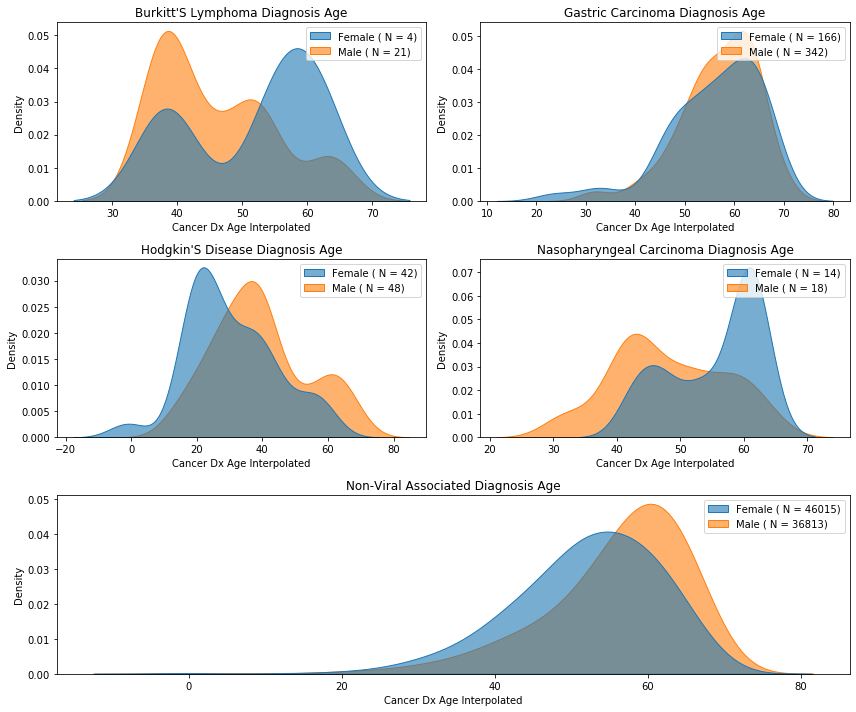

In [81]:
grouping = ICD10_data.groupby(["virus_associated_status"])
grouping = {label: subset for label, subset in grouping}

x, y, hue = "cancer_dx_age_interpolated", "density", "sex"

fig, axes = create_subplot(len(grouping), width=12, height_per=3)
for (cancer_type, subset), ax in zip(ICD10_data.groupby(["virus_associated_status"]), axes):
    sns_wrapper(sns.kdeplot, data=subset, x=x, hue=hue, ax=ax, bw_method=.4, common_norm=False, shade=True)
#     sns.histplot(data=subset, x=x, hue=hue, ax=ax, multiple="dodge", alpha=.3)
    add_plt_labels(ax, x=x, y=y)
    ax.set_title(f"{cancer_type.title()} Diagnosis Age")

fig.tight_layout()

# Example Plot